In [1]:
import scanpy as sc
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
from pathreg import L0_MLP, ODEBlock, PathReg, L1
import torch.optim as optim
from tqdm import tqdm

In [2]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
device="cuda"

In [3]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scCFM/data/eb/processed/eb_phate.h5ad")

/home/icb/alessandro.palma/miniconda3/envs/velocity_benchmarks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/velocity_benchmarks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


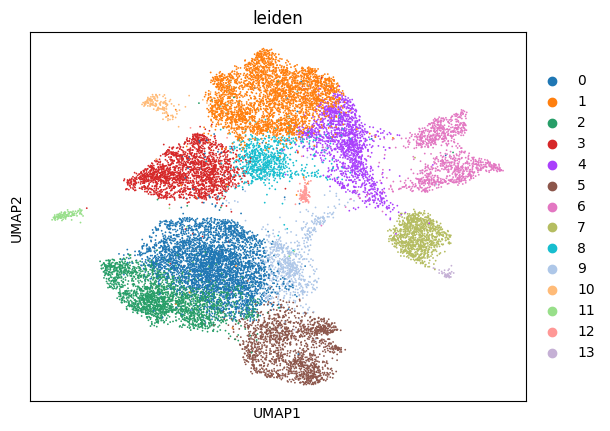

In [4]:
sc.pl.umap(adata, color="leiden") 

In [5]:
sc.tl.diffmap(adata)

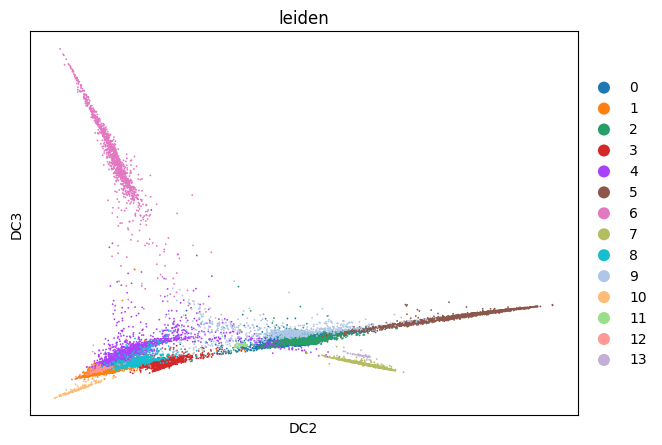

In [6]:
root_ixs = np.flatnonzero(adata.obs['leiden'] == '7')[0]
sc.pl.scatter(
    adata,
    basis="diffmap",
    color=["leiden"],
    components=[2, 3],
)

adata.uns["iroot"] = root_ixs

In [7]:
sc.tl.dpt(adata)

/home/icb/alessandro.palma/miniconda3/envs/velocity_benchmarks/lib/python3.9/site-packages/scanpy/plotting/_utils.py:715: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


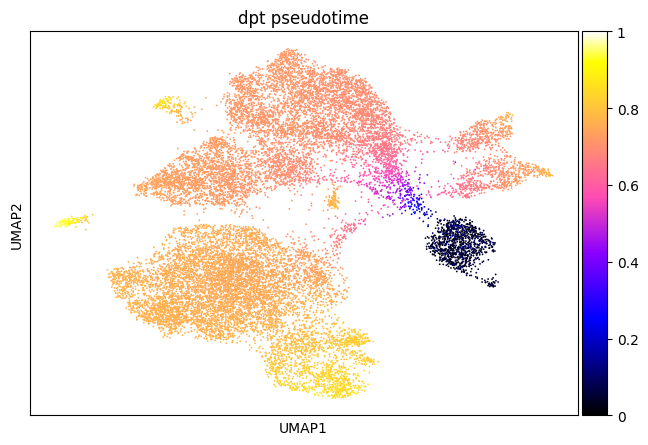

In [8]:
sc.pl.scatter(
    adata,
    basis="umap",
    color=["dpt_pseudotime"],
    color_map="gnuplot2",
)

**Pathreg implementation**

In [9]:
# num_bins = 51

# # Create pseudotime bins
# bin_edges = np.linspace(0, 1, num_bins + 1)
# adata.obs['dpt_pseudotime'] = pd.cut(adata.obs['dpt_pseudotime'], bins=bin_edges, labels=False, include_lowest=True)*(1/(num_bins-1))

# # Print the first few rows of the updated annotation
# print(adata.obs[['dpt_pseudotime']])

In [10]:
nhidden = 100
data_dim = adata.shape[1]
feature_layers = [ODEBlock(
                      L0_MLP(input_dim=data_dim, layer_dims=(nhidden,nhidden,data_dim), N=150),
                      data_dim
                  )]
model = nn.Sequential(*feature_layers).to(device)
loss_func = nn.MSELoss()
print(model)

/home/icb/alessandro.palma/environment/scCFM/notebooks/rebuttals/comparison_velocity_models/L0_regularization.py:47: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.weights, mode='fan_out')


L0Dense(1241 -> 100, droprate_init=0.2, lamba=1.0, temperature=0.6666666666666666, weight_decay=0.0, local_rep=False)
L0Dense(100 -> 100, droprate_init=0.5, lamba=1.0, temperature=0.6666666666666666, weight_decay=0.0, local_rep=False)
L0Dense(100 -> 1241, droprate_init=0.5, lamba=1.0, temperature=0.6666666666666666, weight_decay=0.0, local_rep=False)
Using temporal averaging with beta: 0.999
Sequential(
  (0): ODEBlock(
    (odefunc): L0_MLP(
      (output): Sequential(
        (0): L0Dense(1241 -> 100, droprate_init=0.2, lamba=1.0, temperature=0.6666666666666666, weight_decay=0.0, local_rep=False)
        (1): ELU(alpha=1)
        (2): L0Dense(100 -> 100, droprate_init=0.5, lamba=1.0, temperature=0.6666666666666666, weight_decay=0.0, local_rep=False)
        (3): L0Dense(100 -> 1241, droprate_init=0.5, lamba=1.0, temperature=0.6666666666666666, weight_decay=0.0, local_rep=False)
      )
    )
  )
)


In [11]:
adata = adata[np.argsort(adata.obs['dpt_pseudotime'].values), :]

**Train**

In [12]:
# Unique values 
times, to_keep = np.unique(adata.obs.dpt_pseudotime, return_index=True)
times = torch.tensor(times).to(device)[:-1]

X_train = torch.tensor(adata.X.A[to_keep][:-1]).to(device)
X_pred = torch.tensor(adata.X.A[to_keep][1:]).to(device)

In [13]:
times.shape

torch.Size([18113])

In [14]:
optimizer = optim.Adam(model.parameters(), 0.001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.5, 20,1e-6,'rel',min_lr=1e-16,verbose=True)
loss_func = nn.MSELoss()

In [16]:
for iter in tqdm(range(1000)):
    sample_idx = torch.sort(torch.randperm(times.numel())[:256])[0]
    model[0].set_times(times[sample_idx])
    pred = model[0](X_train[0].unsqueeze(0)).squeeze()
    loss_recon = loss_func(pred, X_pred[sample_idx])
    path_reg = PathReg(model)
    l1_reg = L1(model)
    loss = loss_recon + 0.01 * l1_reg + 0.0001 * path_reg
    loss.backward()
    optimizer.step()      
    if iter%100 == 0:
        print(loss)

  0%|          | 1/1000 [00:00<13:32,  1.23it/s]

tensor(0.4261, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█         | 101/1000 [00:46<08:47,  1.71it/s]

tensor(0.3919, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██        | 201/1000 [02:34<25:36,  1.92s/it]

tensor(0.5099, device='cuda:0', grad_fn=<AddBackward0>)


 30%|███       | 301/1000 [07:28<45:41,  3.92s/it]

tensor(0.7245, device='cuda:0', grad_fn=<AddBackward0>)


 35%|███▌      | 351/1000 [11:48<21:49,  2.02s/it]  


KeyboardInterrupt: 

In [ ]:
torch.cat(torch.tensor([0]),
                          sample_idx)

In [ ]:
torch.tensor([0])

In [ ]:
sample_idx = torch.sort(torch.randperm(times.numel()))[0]

In [28]:
sample_idx

tensor([    0,     1,     2,  ..., 18110, 18111, 18112])